In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

# Clustering using k-means

K-means is the most straightforward algorithm for splitting the dataset $\mathbf{x}_{1:n}$ in $K$ clusters.
If you want to study the algorithm independently, I suggest reading [Chapter 20.1, D. MacKay (2003)](http://www.inference.org.uk/mackay/itprnn/ps/284.292.pdf).

In K-means the clusters are defined by their centroids $\mathbf{m}_{1:K}$, which are the means of the data points assigned to the cluster.
Each observation $\mathbf{x}_i$ is assigned to the cluster with the closest centroid.
We can write this assignment as a one-hot encoding $\mathbf{z}_i$ of the cluster index $k$:

$$
\mathbf{z}_i = \begin{bmatrix} 0 \\ \vdots \\ 1 \\ \vdots \\ 0 \end{bmatrix} \in \mathbb{R}^K, \quad \text{where} \quad z_{ik} = \begin{cases} 1 & \text{if } k = \arg\min_{k'} \|\mathbf{x}_i - \mathbf{m}_{k'}\|^2 \\ 0 & \text{otherwise} \end{cases}
$$

The centroids are found by minimizing the sum of squared distances between the data points and their assigned centroids:

$$
\min_{\mathbf{m}_{1:K}} \sum_{i=1}^n \sum_{k=1}^K z_{ik} \|\mathbf{x}_i - \mathbf{m}_k\|^2
$$

The algorithm starts by initializing the centroids randomly.
Then, it iterates between two steps until convergence:
1. Assign each data point to the cluster with the closest centroid.
2. Update the centroids to the mean of the data points assigned to the cluster.
Convergence is checked by comparing the centroids of the current and previous iteration.
The algorithm is guaranteed to converge, but it may converge to a local minimum.

There is a nice [visualization of the algorithm](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/) by Naftali Harris.

````{admonition} Proof of convergence
:class: dropdown
Notice that the sum of squared distances is minimized when the centroids are the means of the data points assigned to the cluster:

$$
\frac{\partial}{\partial \mathbf{m}_k} \sum_{i=1}^n \sum_{k=1}^K z_{ik} \|\mathbf{x}_i - \mathbf{m}_k\|^2 = 0 \quad \Rightarrow \quad \mathbf{m}_k = \frac{\sum_{i=1}^n z_{ik} \mathbf{x}_i}{\sum_{i=1}^n z_{ik}}
$$

Then, notice that the sum of squared distances is non-increasing in each iteration:

$$
\sum_{i=1}^n \sum_{k=1}^K z_{ik} \|\mathbf{x}_i - \mathbf{m}_k\|^2 \geq \sum_{i=1}^n \sum_{k=1}^K z_{ik} \|\mathbf{x}_i - \mathbf{m}'_k\|^2
$$

where $\mathbf{m}'_k$ are the centroids of the previous iteration.

The sequence of losses is a non-increasing sequence of real numbers, which is bounded below by zero.
Therefore, the sequence converges to a local minimum:

$$
\sum_{i=1}^n \sum_{k=1}^K z_{ik} \|\mathbf{x}_i - \mathbf{m}_k\|^2 \geq \sum_{i=1}^n \sum_{k=1}^K z_{ik} \|\mathbf{x}_i - \mathbf{m}'_k\|^2 \geq \ldots \geq \sum_{i=1}^n \sum_{k=1}^K z_{ik} \|\mathbf{x}_i - \mathbf{m}^*_k\|^2
$$

where $\mathbf{m}^*_k$ are the centroids of the local minimum.
```

The algorithm is equivalent to a Gaussian mixture model with a diagonal covariance matrix and equal covariance for all clusters.
We will learn more about Gaussian mixture models in the next section.

The algorithm is implemented in [sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).
If there is a lot of data or the data is high-dimensional, the algorithm can be slow.
In that case you can use [mini-batch K-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html) or [K-means++](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).


## Example
Let's start by generating a synthetic dataset using with three clusters:

In [2]:
np.random.seed(123456)

# Make synthetic dataset for clustering
num_clusters_true = 3
# The means of each cluster
mu_true = 3.0 * np.random.randn(num_clusters_true, 2)
# The variance of the observations around the cluster
sigma_true = 0.5
# How many observations to generate per cluster
num_obs_cluster = [50, 50, 50]

# Generate the data
data = []
for i in range(num_clusters_true):
    x_i = mu_true[i] + sigma_true * np.random.randn(num_obs_cluster[i], 2)
    data.append(x_i)
data = np.vstack(data)
# Permute the data so that order info is lost
data = np.random.permutation(data)

Now let's visualize the data forgetting about the underlying clusers that gave rise to them.

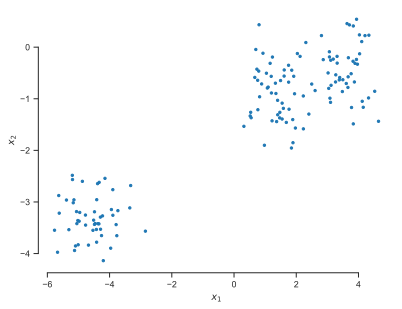

In [11]:
fig, ax = plt.subplots()
ax.plot(data[:, 0], data[:, 1], '.')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
sns.despine(trim=True);

Let's apply K-means to the data:

In [5]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3, n_init='auto').fit(data)

Here is how you can access the cluster centers (the $\mu_k$'s) from the trained model:

In [6]:
model.cluster_centers_

array([[ 3.55976184, -0.43723791],
       [-4.57184776, -3.2974181 ],
       [ 1.35520175, -0.91177514]])

Compare the identified cluster centers to the actual cluster centers:

In [7]:
mu_true

array([[ 1.4073369 , -0.84859003],
       [-4.52717551, -3.40689711],
       [ 3.63633608, -0.51964395]])

K-means has also labeled each observation point with its cluster id.
Here is how to get this info:

In [8]:
model.labels_

array([2, 2, 1, 1, 1, 1, 0, 1, 2, 0, 0, 2, 1, 1, 2, 0, 0, 2, 1, 1, 0, 0,
       1, 1, 2, 2, 0, 2, 2, 2, 0, 0, 2, 1, 0, 2, 1, 2, 0, 0, 2, 0, 2, 0,
       0, 0, 1, 2, 1, 0, 0, 0, 1, 0, 1, 1, 2, 0, 2, 1, 2, 2, 0, 2, 0, 0,
       1, 0, 1, 1, 2, 2, 1, 1, 1, 2, 1, 0, 2, 1, 2, 2, 0, 1, 2, 1, 1, 2,
       0, 0, 2, 2, 0, 1, 2, 0, 2, 2, 0, 2, 0, 1, 1, 0, 1, 2, 1, 1, 0, 1,
       1, 2, 2, 2, 1, 2, 2, 1, 0, 2, 0, 1, 1, 0, 2, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 2, 2, 0, 2, 0, 2, 1, 0, 2, 0, 2, 1, 2, 2], dtype=int32)

Since we have 2D observations, we can actually visualize the clusters.
Here is a nice way to do this:

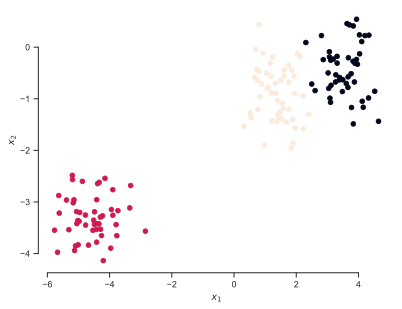

In [12]:
labels = model.predict(data)
fig, ax = plt.subplots()
plt.scatter(data[:, 0], data[:, 1], c=labels)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
sns.despine(trim=True);

Okay, this seems to work perfectly.
However, notice that we asked K-means to find three clusters which happens to be the true number of clusters in our dataset.
What would happen if we had asked K-means to find a larger number of clusters, say 5?
Here it is:

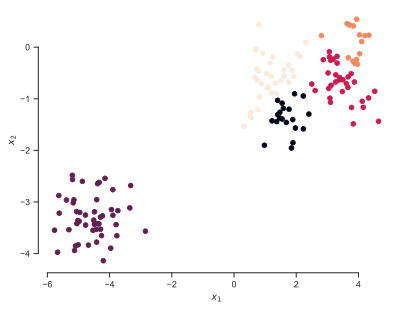

In [13]:
model5 = KMeans(n_clusters=5, n_init='auto').fit(data)

labels = model5.predict(data)

fig, ax = plt.subplots()
plt.scatter(data[:, 0], data[:, 1], c=labels)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
sns.despine(trim=True);

### Questions
+ We saw what happens when you ask K-means to find more clusters than there exist. What would happen if you asked it to find fewer clusters? Try $K=1$ and $K=2$ in the code block immediately above. What do you observe? Can choose between $K=1, 2,$ or $3$?
+ Rerun the entire example from the first code block, but set the number of true clusters to 6 this time. Investigate what happens when you try to fit K-means with a minimal number of clusters, what happens when you pick $K$ to be around 6, and what happens when you pick a very big $K$, say 10.